## DECISION TREE POST PRUNING

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf

df = pd.read_csv('dataset/df_clean.csv')


Split del dataset pulito ed encodato

In [35]:
# Definizione di X e y
X = df.drop(['Crime_Category', 'Crime_Category_Encoded'], axis=1)
y = df['Crime_Category_Encoded']

In [36]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Prima devo trovare i valori di ccp_alpha

In [37]:
# mi dà una lista di valori ccp_alpha crescenti
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train) 
# assegna i risultati alla variabile ccp_alpha
ccp_alphas = path.ccp_alphas

Addestramento di più alberi con ccp_alpha

In [38]:
trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)


In [39]:
# Valutazione di ogni albero sull'insieme di test
test_scores = [accuracy_score(y_test, tree.predict(X_test)) for tree in trees]

Migliore Albero Post-Pruned

In [40]:
best_index = test_scores.index(max(test_scores))
best_tree = trees[best_index]
print(f"Miglior ccp_alpha: {ccp_alphas[best_index]}")

Miglior ccp_alpha: 0.0001392322954822955


In [41]:
# Creiamo l'albero e bilanciamo le classi
best_tree = DecisionTreeClassifier(
    random_state=42,
    ccp_alpha=0.0001392322954822955,
    class_weight='balanced'
)
best_tree.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0001392322954822955, class_weight='balanced',
                       random_state=42)

              precision    recall  f1-score   support

           0       0.36      0.56      0.43        45
           1       0.23      0.27      0.25       362
           2       0.35      0.66      0.46       271
           3       0.05      0.11      0.07        36
           4       0.94      0.80      0.86      2333
           5       0.75      0.75      0.75       953

    accuracy                           0.72      4000
   macro avg       0.45      0.52      0.47      4000
weighted avg       0.78      0.72      0.74      4000



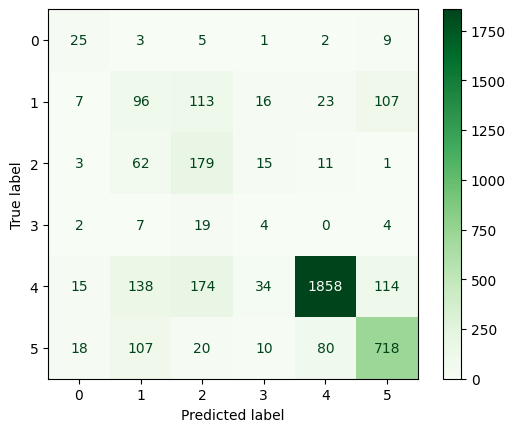

In [42]:
# Valutazione Modello
y_pred = best_tree.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_tree, X_test, y_test, cmap='Greens')

### Punti forti
Property Crimes (classe 4) ha un f1-score altissimo (0.86) = il modello la classifica molto bene.

Violent Crimes (classe 5) ha buoni risultati (f1 = 0.75).

Fraud and White-Collar Crimes (classe 2) migliora col bilanciamento (recall 0.66, f1 = 0.46).

### Criticità
Other Crimes (classe 3) = praticamente non viene riconosciuta (f1 = 0.07).

Crimes against Public Order (classe 1) ha ancora f1 = 0.25.

Crimes against Persons (classe 0) = piccolo campione (support = 45) ma almeno f1 = 0.43.

### Prime Osservazioni
Il modello con class_weight='balanced' ha aiutato molto le classi meno frequenti, in particolare classe 2.

Le classi 4 e 5 dominano la performance totale = il modello rischia di essere trainato da esse.

Alcune classi (1 e 3) restano problematiche:

Si potrebbe considerare **SMOTE** per oversampling delle classi minoritarie

In [43]:
# Applichiamo SMOTE solo alle classi 1 e 3

# Isolo le classi 1 e 3
mask_minority = y_train.isin([1, 3])
X_minority = X_train[mask_minority]
y_minority = y_train[mask_minority]

# SMOTE solo su quelle
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_minority, y_minority)

# Unisco i dati SMOTE ai dati originali
X_train_bal = pd.concat([X_train, X_smote], axis=0)
y_train_bal = pd.concat([y_train, y_smote], axis=0)


              precision    recall  f1-score   support

           0       0.61      0.44      0.51        45
           1       0.27      0.30      0.28       362
           2       0.44      0.38      0.40       271
           3       0.04      0.08      0.05        36
           4       0.88      0.87      0.87      2333
           5       0.71      0.70      0.70       953

    accuracy                           0.73      4000
   macro avg       0.49      0.46      0.47      4000
weighted avg       0.74      0.73      0.74      4000



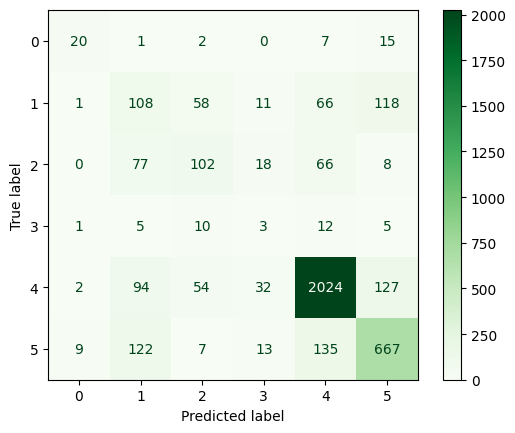

In [44]:
# Addestro il modello con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

y_pred = rf.predict(X_test)

# Valutazione nuove metriche
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Greens')


### Conclusioni Decision Tree Post-Pruning con bilanciamento classi e SMOTE
**Cosa è migliorato**

La classe 1 (Crimes against Public Order) migliora un po’

La classe 3 resta molto difficile, ma ora il modello almeno la vede

**Cosa rimane critico**

La classe 3 continua ad avere poche istanze (support = 36), quindi SMOTE ha aiutato ma non basta.

Le predizioni si concentrano ancora sulle classi 4 e 5 (i “soliti noti”).

# RANDOM FOREST

In [45]:
# Creo il modello con class_weight balanced
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Addestramento
rf.fit(X_train, y_train)

# Predizioni
y_pred = rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.60      0.47      0.53        45
           1       0.26      0.21      0.23       362
           2       0.43      0.45      0.44       271
           3       0.00      0.00      0.00        36
           4       0.86      0.89      0.87      2333
           5       0.73      0.74      0.73       953

    accuracy                           0.75      4000
   macro avg       0.48      0.46      0.47      4000
weighted avg       0.74      0.75      0.74      4000



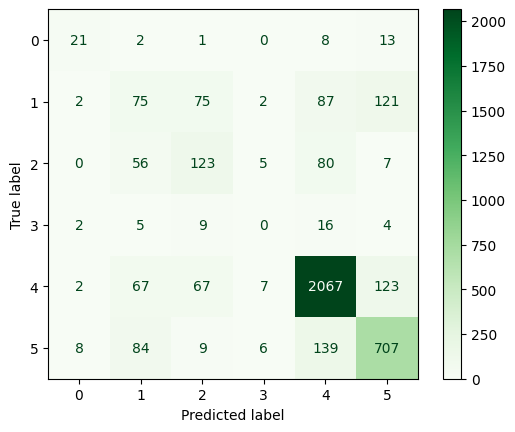

In [46]:
# Report classificazione
print(classification_report(y_test, y_pred))

# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Greens')

# PROVIAMO CON XGBOOST

In [47]:
pip install xgboost --user

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Francesca\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [48]:
from xgboost import XGBClassifier

# addestriamo il modello e facciamo predizione
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=6,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

C:\Users\Francesca\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [20:20:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.60      0.47      0.53        45
           1       0.37      0.14      0.20       362
           2       0.46      0.56      0.50       271
           3       0.00      0.00      0.00        36
           4       0.86      0.91      0.89      2333
           5       0.76      0.82      0.79       953

    accuracy                           0.78      4000
   macro avg       0.51      0.48      0.48      4000
weighted avg       0.76      0.78      0.76      4000



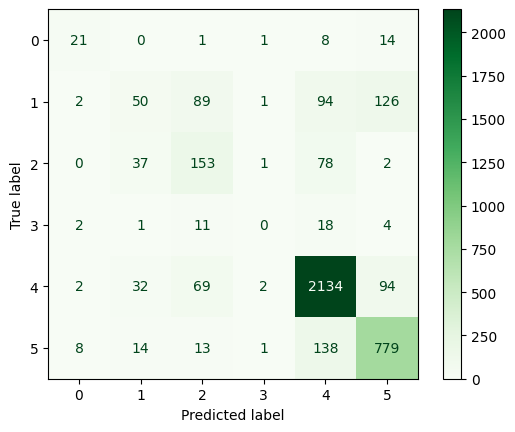

In [49]:
# Metriche

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Greens')


# CONCLUSIONE
COSA FUNZIONA BENE?
+ Property Crimes (4)	Ottimo f1-score: 0.89  = modello super preciso e affidabile su questa classe dominante
+ Violent Crimes (5)	f1-score alto: 0.79
+ Fraud and White-Collar (2)	f1-score 0.50, migliore tra le minoritarie

COSA RESTA DEBOLE
+ Crimes against Public Order (1)	f1-score 0.20, recall molto basso (0.14)
+ Other Crimes (3)	f1-score 0.00, completamente ignorata

METRICHE GLOBALI
+ Weighted avg è alto perché il modello lavora bene sulle classi grandi.
+ Macro avg evidenzia la debolezza sulle classi minoritarie (1 e 3).

**QUINDI**
+ Abbiamo provato con: bilanciamento, pruning, SMOTE, Random Forest e XGB	
+ Le classi 1 e 3 sono difficili da predire: occorre più dati o feature ingegnose	
+ XGBoost è il migliore finora come equilibrio tra accuratezza e recall